In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot

from spike_statistics.core import permutation_resampling

15:56:22 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  burst_event_ratio  \
0           NaN       False  baseline ii  ...           0.397921   
1           NaN       False  baseline ii  ...           0.146481   
2           NaN       False  baseline ii  ...           0.373466   
3           NaN       False  baseline ii  ...           0.097464   
4           NaN       False  baseline ii  ...           0.248036   

   bursty_spike_ratio  gridness border_score  information_rate  \
0            0.676486 -0.459487     0.078474          0.965845   
1            0.277121 -0.615405     0.311180          0.191375   
2            0.658748 -0.527711     0.131660          3.833587   
3            0.196189 -0.641543     0.274989          0.153740   
4            0.461250 -0.085292     0.198676          0.526720   

   information_specificity  head_mean_ang  head_mean_vec_len   spacing  \
0                 0.309723       5.788704           0.043321  0.624971   
1                 0.032266       1.821598           0.014624  0.753333   
2                 0.336590       4.407614           0.121115  0.542877   
3                 0.068626       6.128601           0.099223  0.484916   
4                 0.033667       1.602362           0.051825  0.646571   

   orientation  
0    22.067900  
1     0.000000  
2    27.758541  
3    11.309932  
4     0.000000  

[5 rows x 34 columns]

In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

border_score  gridness  head_mean_ang  head_mean_vec_len  information_rate  \
0      0.348023  0.275109       3.012689           0.086792          0.707197   
1      0.362380  0.166475       3.133138           0.037271          0.482486   
2      0.367498  0.266865       5.586395           0.182843          0.271188   
3      0.331942  0.312155       5.955767           0.090786          0.354018   
4      0.325842  0.180495       5.262721           0.103584          0.210427   

   speed_score         action  channel_group  unit_name  
0     0.149071  1833-010719-1            0.0      127.0  
1     0.132212  1833-010719-1            0.0      161.0  
2     0.062821  1833-010719-1            0.0      191.0  
3     0.052009  1833-010719-1            0.0      223.0  
4     0.094041  1833-010719-1            0.0      225.0

In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

action  baseline  entity  frequency      i    ii  session  \
0  1849-060319-3      True    1849        NaN  False  True        3   
1  1849-060319-3      True    1849        NaN  False  True        3   
2  1849-060319-3      True    1849        NaN  False  True        3   
3  1849-060319-3      True    1849        NaN  False  True        3   
4  1849-060319-3      True    1849        NaN  False  True        3   

  stim_location  stimulated          tag  ...  head_mean_vec_len   spacing  \
0           NaN       False  baseline ii  ...           0.043321  0.624971   
1           NaN       False  baseline ii  ...           0.014624  0.753333   
2           NaN       False  baseline ii  ...           0.121115  0.542877   
3           NaN       False  baseline ii  ...           0.099223  0.484916   
4           NaN       False  baseline ii  ...           0.051825  0.646571   

   orientation border_score_threshold  gridness_threshold  \
0    22.067900               0.332548            0.229073   
1     0.000000               0.354830            0.089333   
2    27.758541               0.264610           -0.121081   
3    11.309932               0.344280            0.215829   
4     0.000000               0.342799            0.218967   

   head_mean_ang_threshold  head_mean_vec_len_threshold  \
0                 6.029431                     0.205362   
1                 6.120055                     0.073566   
2                 5.759406                     0.150827   
3                 6.033364                     0.110495   
4                 5.768170                     0.054762   

   information_rate_threshold  speed_score_threshold  specificity  
0                    1.115825               0.066736     0.445206  
1                    0.223237               0.052594     0.097485  
2                    4.964984               0.027120     0.393687  
3                    0.239996               0.054074     0.262612  
4                    0.524990               0.144702     0.133677  

[5 rows x 41 columns]

# Statistics about all cell-sessions

In [12]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     674
Name: action, dtype: int64

# Find all cells with gridness above threshold

In [11]:
query = 'gridness > gridness_threshold and information_rate > information_rate_threshold'
sessions_above_threshold = data.query(query)
print("Number of gridcells", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of gridcells 226
Number of animals 4


In [13]:
baseline = sessions_above_threshold.query('baseline')

In [14]:
gridcell_in_baseline = data[data.unit_id.isin(baseline.unit_id)]

In [18]:
baseline_i = gridcell_in_baseline.query('baseline and i')
stimulated_11 = gridcell_in_baseline.query('frequency==11 and stim_location=="ms" and i')

baseline_ii = gridcell_in_baseline.query('baseline and ii')
stimulated_30 = gridcell_in_baseline.query('frequency==30 and stim_location=="ms" and ii')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 78
Number of gridcells in stimulated 11Hz ms sessions 35
Number of gridcells in baseline ii sessions 66
Number of gridcells in stimulated 30Hz ms sessions 33


# slice unique units

In [19]:
baseline_i = baseline_i.drop_duplicates('unit_id')
stimulated_11 = stimulated_11.drop_duplicates('unit_id')
baseline_ii = baseline_ii.drop_duplicates('unit_id')
stimulated_30 = stimulated_30.drop_duplicates('unit_id')

In [20]:
print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 68
Number of gridcells in stimulated 11Hz ms sessions 32
Number of gridcells in baseline ii sessions 58
Number of gridcells in stimulated 30Hz ms sessions 28


# Calculate statistics

In [21]:
columns = [
    'average_rate', 'gridness', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 
    'in_field_mean_rate', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score'
]

In [22]:
gridcell_in_baseline.groupby('stimulated')[columns].mean()

average_rate  gridness  sparsity  selectivity  \
stimulated                                                  
False           9.928801  0.562122  0.656634     5.320886   
True            9.554733  0.365628  0.666120     6.232196   

            information_specificity   max_rate  information_rate  \
stimulated                                                         
False                      0.200475  37.440262          1.178277   
True                       0.194542  39.864795          1.063930   

            interspike_interval_cv  in_field_mean_rate  out_field_mean_rate  \
stimulated                                                                    
False                     2.348004           15.711336             7.319828   
True                      2.328150           14.582445             7.121023   

            burst_event_ratio  specificity  speed_score  
stimulated                                               
False                0.219627     0.444021     0.136236  
True                 0.205369     0.445532     0.102438

In [23]:
gridcell_in_baseline.query('baseline')[columns].describe()

average_rate    gridness    sparsity  selectivity  \
count    144.000000  144.000000  144.000000   144.000000   
mean       9.928801    0.562122    0.656634     5.320886   
std        7.727249    0.338826    0.186070     2.885443   
min        0.516375   -0.360777    0.261912     1.842905   
25%        3.833480    0.350175    0.517566     3.108402   
50%        7.101159    0.595244    0.701089     4.682344   
75%       15.349392    0.802880    0.820432     6.619374   
max       31.367451    1.174288    0.954505    17.011330   

       information_specificity    max_rate  information_rate  \
count               144.000000  144.000000        144.000000   
mean                  0.200475   37.440262          1.178277   
std                   0.175036   16.512138          0.570617   
min                   0.011661    3.013150          0.122324   
25%                   0.072654   25.189028          0.748273   
50%                   0.139185   34.014566          1.064148   
75%                   0.261063   45.689916          1.562027   
max                   0.918520   90.839266          3.540663   

       interspike_interval_cv  in_field_mean_rate  out_field_mean_rate  \
count              144.000000          144.000000           144.000000   
mean                 2.348004           15.711336             7.319828   
std                  0.743517            9.798591             6.760978   
min                  1.361275            0.993877             0.257364   
25%                  1.772429            7.649203             1.863476   
50%                  2.170671           12.863627             4.773814   
75%                  2.688595           23.123564            10.952948   
max                  5.240845           45.349506            28.721619   

       burst_event_ratio  specificity  speed_score  
count         144.000000   144.000000   144.000000  
mean            0.219627     0.444021     0.136236  
std             0.082774     0.206192     0.075267  
min             0.027228     0.128469    -0.023795  
25%             0.162862     0.289491     0.082031  
50%             0.213065     0.383049     0.130958  
75%             0.280340     0.570619     0.188830  
max             0.400014     0.975050     0.323278

In [24]:
gridcell_in_baseline.query("stimulated")[columns].describe()

average_rate   gridness   sparsity  selectivity  \
count     73.000000  73.000000  73.000000    73.000000   
mean       9.554733   0.365628   0.666120     6.232196   
std        7.334232   0.397430   0.194908     5.760291   
min        1.371102  -0.482293   0.297108     1.920211   
25%        3.596484   0.052315   0.466494     3.531741   
50%        7.237246   0.290593   0.729540     4.476625   
75%       14.029394   0.679854   0.853552     7.867471   
max       31.800150   1.110681   0.925871    45.427380   

       information_specificity    max_rate  information_rate  \
count                73.000000   73.000000         73.000000   
mean                  0.194542   39.864795          1.063930   
std                   0.161491   25.342874          0.478339   
min                   0.020735   10.492070          0.292174   
25%                   0.072324   25.324427          0.707876   
50%                   0.113483   33.048050          0.993926   
75%                   0.307852   46.159854          1.242135   
max                   0.678935  199.999821          2.918984   

       interspike_interval_cv  in_field_mean_rate  out_field_mean_rate  \
count               73.000000           73.000000            73.000000   
mean                 2.328150           14.582445             7.121023   
std                  0.731921            8.551638             6.482068   
min                  1.332239            3.531824             0.573040   
25%                  1.742983            8.127398             1.813572   
50%                  2.212266           12.308800             4.675997   
75%                  2.822726           19.752448            10.723556   
max                  4.604317           39.093347            25.836762   

       burst_event_ratio  specificity  speed_score  
count          73.000000    73.000000    73.000000  
mean            0.205369     0.445532     0.102438  
std             0.075895     0.230698     0.077154  
min             0.042956     0.137978    -0.072000  
25%             0.159265     0.248962     0.052617  
50%             0.199137     0.365960     0.094618  
75%             0.261186     0.670842     0.139564  
max             0.406678     0.966010     0.336072

# Create nice table

In [25]:
def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(column, stim, base):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        stim[column].dropna(), 
        base[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column, stim, base):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        stim[column].dropna(), 
        base[column].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [26]:
_stim_data = gridcell_in_baseline.query('stimulated')
_base_data = gridcell_in_baseline.query('baseline')

result = pd.DataFrame()

result['Stimulated'] = _stim_data[columns].agg(summarize)
result['Baseline'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))

result.to_latex(output_path / "statistics" / "statistics.tex")
result.to_latex(output_path / "statistics" / "statistics.csv")
result

Stimulated            Baseline  \
Average rate              9.55 ± 0.86 (73)   9.93 ± 0.64 (144)   
Gridness                  0.37 ± 0.05 (73)   0.56 ± 0.03 (144)   
Sparsity                  0.67 ± 0.02 (73)   0.66 ± 0.02 (144)   
Selectivity               6.23 ± 0.67 (73)   5.32 ± 0.24 (144)   
Information specificity   0.19 ± 0.02 (73)   0.20 ± 0.01 (144)   
Max rate                 39.86 ± 2.97 (73)  37.44 ± 1.38 (144)   
Information rate          1.06 ± 0.06 (73)   1.18 ± 0.05 (144)   
Interspike interval cv    2.33 ± 0.09 (73)   2.35 ± 0.06 (144)   
In-field mean rate       14.58 ± 1.00 (73)  15.71 ± 0.82 (144)   
Out-field mean rate       7.12 ± 0.76 (73)   7.32 ± 0.56 (144)   
Burst event ratio         0.21 ± 0.01 (73)   0.22 ± 0.01 (144)   
Specificity               0.45 ± 0.03 (73)   0.44 ± 0.02 (144)   
Speed score               0.10 ± 0.01 (73)   0.14 ± 0.01 (144)   

                                    MWU          PRS  
Average rate             5120.00, 0.757  0.14, 0.868  
Gridness                 3718.00, 0.000  0.30, 0.000  
Sparsity                 5515.00, 0.554  0.03, 0.413  
Selectivity              5482.00, 0.606  0.21, 0.718  
Information specificity  5094.00, 0.712  0.03, 0.501  
Max rate                 5256.00, 0.999  0.97, 0.592  
Information rate         4681.00, 0.189  0.07, 0.426  
Interspike interval cv   5197.00, 0.894  0.04, 0.715  
In-field mean rate       5000.00, 0.559  0.55, 0.751  
Out-field mean rate      5166.00, 0.838  0.10, 0.934  
Burst event ratio        4677.00, 0.186  0.01, 0.212  
Specificity              5076.00, 0.681  0.02, 0.547  
Speed score              3978.00, 0.003  0.04, 0.008

In [27]:
_stim_data = stimulated_11
_base_data = baseline_i

result = pd.DataFrame()

result['Stimulated'] = _stim_data[columns].agg(summarize)
result['Baseline'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_11.tex")
result.to_latex(output_path / "statistics" / "statistics_11.csv")
result

Stimulated           Baseline             MWU  \
Average rate              9.06 ± 1.21 (32)   9.65 ± 0.90 (68)  1044.00, 0.748   
Gridness                  0.34 ± 0.06 (32)   0.58 ± 0.04 (68)   676.00, 0.002   
Sparsity                  0.67 ± 0.03 (32)   0.65 ± 0.02 (68)  1154.00, 0.628   
Selectivity               5.43 ± 0.47 (32)   5.22 ± 0.35 (68)  1140.00, 0.704   
Information specificity   0.19 ± 0.03 (32)   0.21 ± 0.02 (68)  1005.00, 0.542   
Max rate                 35.53 ± 2.50 (32)  36.19 ± 1.79 (68)  1063.00, 0.856   
Information rate          1.04 ± 0.10 (32)   1.21 ± 0.06 (68)   867.00, 0.103   
Interspike interval cv    2.29 ± 0.12 (32)   2.38 ± 0.10 (68)  1053.00, 0.799   
In-field mean rate       13.87 ± 1.42 (32)  15.27 ± 1.12 (68)  1024.00, 0.639   
Out-field mean rate       6.52 ± 1.04 (32)   6.98 ± 0.76 (68)  1037.00, 0.709   
Burst event ratio         0.23 ± 0.01 (32)   0.23 ± 0.01 (68)  1158.00, 0.608   
Specificity               0.45 ± 0.04 (32)   0.45 ± 0.02 (68)  1060.00, 0.839   
Speed score               0.09 ± 0.01 (32)   0.14 ± 0.01 (68)   736.00, 0.009   

                                 PRS  
Average rate             0.02, 0.997  
Gridness                 0.27, 0.003  
Sparsity                 0.06, 0.319  
Selectivity              0.29, 0.705  
Information specificity  0.05, 0.095  
Max rate                 0.04, 0.972  
Information rate         0.12, 0.225  
Interspike interval cv   0.04, 0.891  
In-field mean rate       0.10, 0.948  
Out-field mean rate      0.35, 0.905  
Burst event ratio        0.01, 0.478  
Specificity              0.01, 0.852  
Speed score              0.05, 0.011

In [28]:
_stim_data = stimulated_30
_base_data = baseline_ii

result = pd.DataFrame()

result['Stimulated'] = _stim_data[columns].agg(summarize)
result['Baseline'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_30.tex")
result.to_latex(output_path / "statistics" / "statistics_30.csv")
result

Stimulated           Baseline            MWU  \
Average rate             10.11 ± 1.51 (28)  10.01 ± 1.06 (58)  808.00, 0.974   
Gridness                  0.28 ± 0.08 (28)   0.57 ± 0.05 (58)  493.00, 0.003   
Sparsity                  0.68 ± 0.04 (28)   0.66 ± 0.02 (58)  881.00, 0.528   
Selectivity               7.47 ± 1.63 (28)   5.53 ± 0.40 (58)  809.00, 0.982   
Information specificity   0.20 ± 0.03 (28)   0.19 ± 0.02 (58)  812.00, 0.996   
Max rate                 45.33 ± 6.85 (28)  38.95 ± 2.48 (58)  797.00, 0.894   
Information rate          1.04 ± 0.08 (28)   1.12 ± 0.09 (58)  799.00, 0.908   
Interspike interval cv    2.28 ± 0.16 (28)   2.32 ± 0.09 (58)  745.00, 0.540   
In-field mean rate       14.95 ± 1.71 (28)  15.81 ± 1.38 (58)  779.00, 0.765   
Out-field mean rate       7.80 ± 1.35 (28)   7.58 ± 0.96 (58)  827.00, 0.894   
Burst event ratio         0.18 ± 0.01 (28)   0.21 ± 0.01 (58)  641.00, 0.116   
Specificity               0.43 ± 0.05 (28)   0.43 ± 0.03 (58)  749.00, 0.565   
Speed score               0.10 ± 0.02 (28)   0.12 ± 0.01 (58)  617.00, 0.073   

                                 PRS  
Average rate             0.07, 0.968  
Gridness                 0.46, 0.000  
Sparsity                 0.04, 0.328  
Selectivity              0.30, 0.638  
Information specificity  0.01, 0.588  
Max rate                 2.09, 0.451  
Information rate         0.03, 0.858  
Interspike interval cv   0.16, 0.463  
In-field mean rate       0.98, 0.712  
Out-field mean rate      0.10, 0.927  
Burst event ratio        0.03, 0.099  
Specificity              0.02, 0.657  
Speed score              0.02, 0.116

In [29]:
_stim_data = stimulated_30
_base_data = stimulated_11

result = pd.DataFrame()

result['Stimulated 30Hz'] = _stim_data[columns].agg(summarize)
result['Stimulated 11Hz'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_11_vs_30.tex")
result.to_latex(output_path / "statistics" / "statistics_11_vs_30.csv")
result

Stimulated 30Hz    Stimulated 11Hz            MWU  \
Average rate             10.11 ± 1.51 (28)   9.06 ± 1.21 (32)  463.00, 0.830   
Gridness                  0.28 ± 0.08 (28)   0.34 ± 0.06 (32)  402.00, 0.500   
Sparsity                  0.68 ± 0.04 (28)   0.67 ± 0.03 (32)  479.00, 0.651   
Selectivity               7.47 ± 1.63 (28)   5.43 ± 0.47 (32)  449.00, 0.994   
Information specificity   0.20 ± 0.03 (28)   0.19 ± 0.03 (32)  440.00, 0.912   
Max rate                 45.33 ± 6.85 (28)  35.53 ± 2.50 (32)  488.00, 0.558   
Information rate          1.04 ± 0.08 (28)   1.04 ± 0.10 (32)  475.00, 0.695   
Interspike interval cv    2.28 ± 0.16 (28)   2.29 ± 0.12 (32)  411.00, 0.589   
In-field mean rate       14.95 ± 1.71 (28)  13.87 ± 1.42 (32)  473.00, 0.717   
Out-field mean rate       7.80 ± 1.35 (28)   6.52 ± 1.04 (32)  489.00, 0.548   
Burst event ratio         0.18 ± 0.01 (28)   0.23 ± 0.01 (32)  273.00, 0.010   
Specificity               0.43 ± 0.05 (28)   0.45 ± 0.04 (32)  400.00, 0.482   
Speed score               0.10 ± 0.02 (28)   0.09 ± 0.01 (32)  446.00, 0.982   

                                 PRS  
Average rate             0.12, 0.978  
Gridness                 0.15, 0.330  
Sparsity                 0.03, 0.493  
Selectivity              0.00, 0.999  
Information specificity  0.01, 0.768  
Max rate                 1.22, 0.682  
Information rate         0.02, 0.775  
Interspike interval cv   0.14, 0.659  
In-field mean rate       1.02, 0.794  
Out-field mean rate      0.17, 0.940  
Burst event ratio        0.05, 0.028  
Specificity              0.02, 0.570  
Speed score              0.01, 0.480

In [30]:
_stim_data = baseline_i
_base_data = baseline_ii

result = pd.DataFrame()

result['Baseline i'] = _stim_data[columns].agg(summarize)
result['Baseline ii'] = _base_data[columns].agg(summarize)

result.index = map(rename, result.index)

result['MWU'] = list(map(lambda x: MWU(x, _stim_data, _base_data), columns))
result['PRS'] = list(map(lambda x: PRS(x, _stim_data, _base_data), columns))


result.to_latex(output_path / "statistics" / "statistics_base_i_vs_base_ii.tex")
result.to_latex(output_path / "statistics" / "statistics_base_i_vs_base_ii.csv")
result

Baseline i        Baseline ii             MWU  \
Average rate              9.65 ± 0.90 (68)  10.01 ± 1.06 (58)  1979.00, 0.975   
Gridness                  0.58 ± 0.04 (68)   0.57 ± 0.05 (58)  1946.00, 0.901   
Sparsity                  0.65 ± 0.02 (68)   0.66 ± 0.02 (58)  1870.00, 0.619   
Selectivity               5.22 ± 0.35 (68)   5.53 ± 0.40 (58)  1833.00, 0.498   
Information specificity   0.21 ± 0.02 (68)   0.19 ± 0.02 (58)  2135.00, 0.426   
Max rate                 36.19 ± 1.79 (68)  38.95 ± 2.48 (58)  1824.00, 0.470   
Information rate          1.21 ± 0.06 (68)   1.12 ± 0.09 (58)  2246.00, 0.181   
Interspike interval cv    2.38 ± 0.10 (68)   2.32 ± 0.09 (58)  2055.00, 0.686   
In-field mean rate       15.27 ± 1.12 (68)  15.81 ± 1.38 (58)  1926.00, 0.824   
Out-field mean rate       6.98 ± 0.76 (68)   7.58 ± 0.96 (58)  1946.00, 0.901   
Burst event ratio         0.23 ± 0.01 (68)   0.21 ± 0.01 (58)  2112.00, 0.495   
Specificity               0.45 ± 0.02 (68)   0.43 ± 0.03 (58)  2035.00, 0.760   
Speed score               0.14 ± 0.01 (68)   0.12 ± 0.01 (58)  2267.00, 0.149   

                                 PRS  
Average rate             0.20, 0.935  
Gridness                 0.04, 0.479  
Sparsity                 0.05, 0.253  
Selectivity              0.01, 0.973  
Information specificity  0.05, 0.136  
Max rate                 0.84, 0.675  
Information rate         0.13, 0.169  
Interspike interval cv   0.02, 0.805  
In-field mean rate       0.15, 0.931  
Out-field mean rate      0.62, 0.650  
Burst event ratio        0.00, 0.743  
Specificity              0.01, 0.834  
Speed score              0.05, 0.014

# Violinplot

In [47]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7, 3), 
    'figure.dpi': 150
})

In [48]:
stuff = {
    '': {
        'base': gridcell_in_baseline.query('baseline'),
        'stim': gridcell_in_baseline.query('stimulated')
    },
    '_11': {
        'base': baseline_i,
        'stim': stimulated_11
    },
    '_30': {
        'base': baseline_ii,
        'stim': stimulated_30
    }
}

# Information rate


U-test: U value 5831.0 p value 0.18862797777215656
_11
U-test: U value 1309.0 p value 0.10324315446274247
_30
U-test: U value 825.0 p value 0.9082875409541091


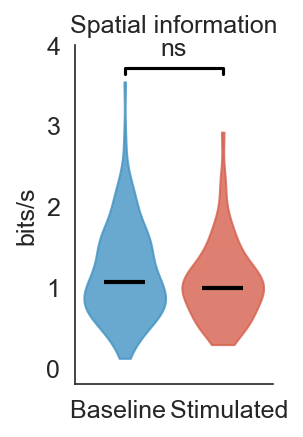

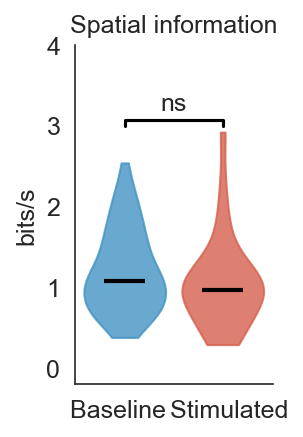

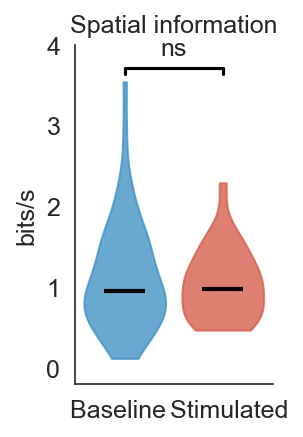

In [49]:

for key, data in stuff.items():
    baseline = data['base']['information_rate'].to_numpy()
    stimulated = data['stim']['information_rate'].to_numpy()
    print(key)
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Spatial information")
    plt.ylabel("bits/s")
    plt.ylim(-0.2, 4)

    plt.savefig(output_path / "figures" / f"spatial_information{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"spatial_information{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5436.0 p value 0.6812512952522969
U-test: U value 1116.0 p value 0.8389752457478267
U-test: U value 875.0 p value 0.5646191993775383


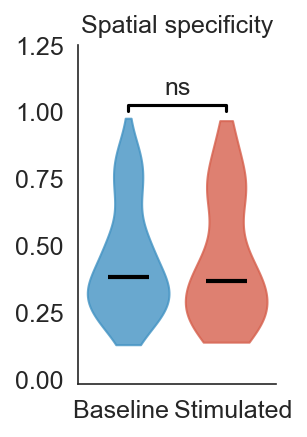

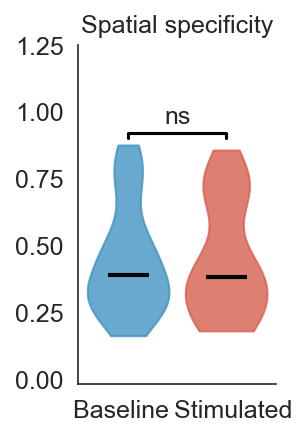

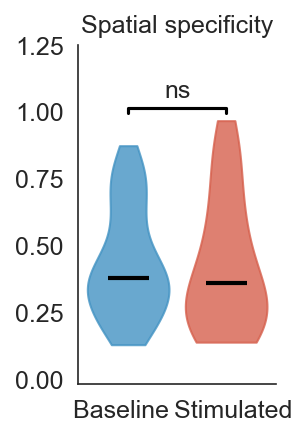

In [50]:
for key, data in stuff.items():
    baseline = data['base']['specificity'].to_numpy()
    stimulated = data['stim']['specificity'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Spatial specificity")
    plt.ylabel("")
    plt.ylim(-0.02, 1.25)
    plt.savefig(output_path / "figures" / f"specificity{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"specificity{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5392.0 p value 0.756508134572621
U-test: U value 1132.0 p value 0.7478826789327293
U-test: U value 816.0 p value 0.9742681632988652


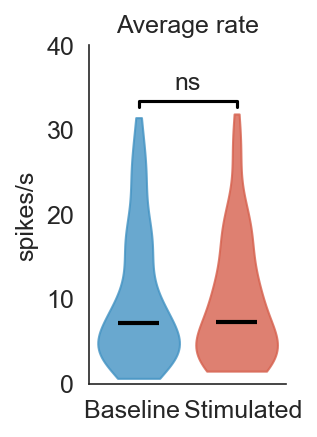

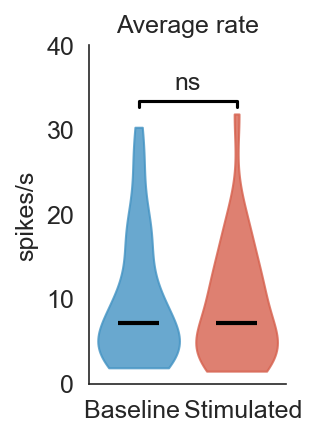

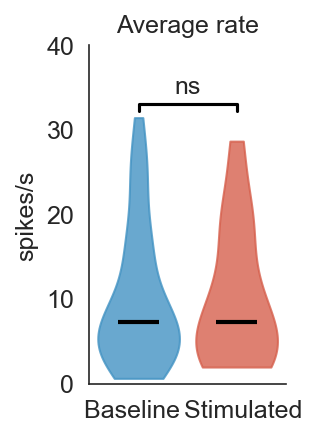

In [51]:

for key, data in stuff.items():
    baseline = data['base']['average_rate'].to_numpy()
    stimulated = data['stim']['average_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Average rate")
    plt.ylabel("spikes/s")
    plt.ylim(-0.2, 40)

    plt.savefig(output_path / "figures" / f"average_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"average_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5256.0 p value 0.9990870864121681
U-test: U value 1113.0 p value 0.8563387857160952
U-test: U value 827.0 p value 0.8936946693232326


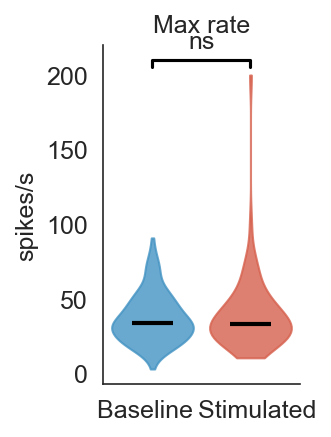

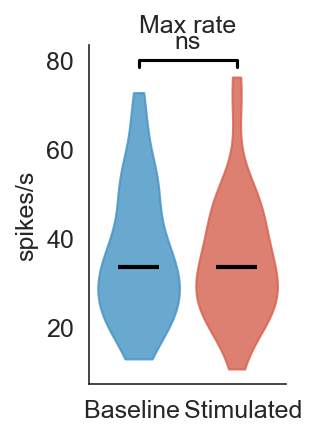

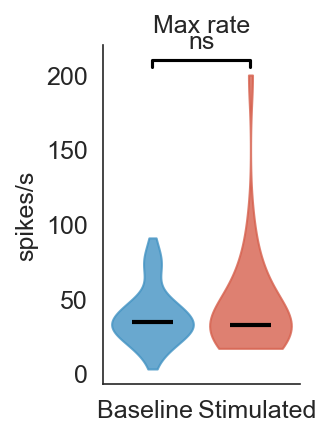

In [52]:
for key, data in stuff.items():
    baseline = data['base']['max_rate'].to_numpy()
    stimulated = data['stim']['max_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Max rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.2, 45)

    plt.savefig(output_path / "figures" / f"max_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"max_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5315.0 p value 0.8935072494346303
U-test: U value 1123.0 p value 0.7987777816762969
U-test: U value 879.0 p value 0.5399704510090971


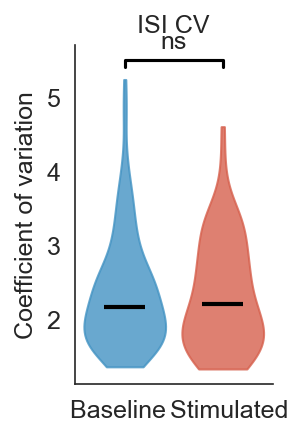

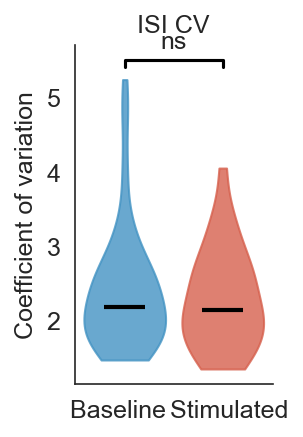

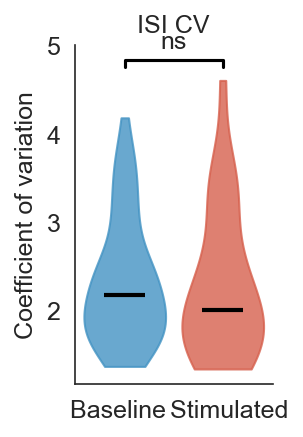

In [53]:

for key, data in stuff.items():
    baseline = data['base']['interspike_interval_cv'].to_numpy()
    stimulated = data['stim']['interspike_interval_cv'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("ISI CV")
    plt.ylabel("Coefficient of variation")
    # plt.ylim(0.9, 5)

    plt.savefig(output_path / "figures" / f"isi_cv{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"isi_cv{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5512.0 p value 0.5587698160186371
U-test: U value 1152.0 p value 0.6389141666384814
U-test: U value 845.0 p value 0.764545672323149


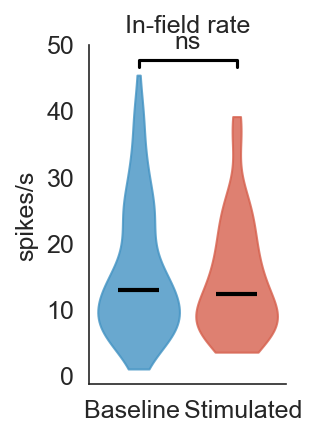

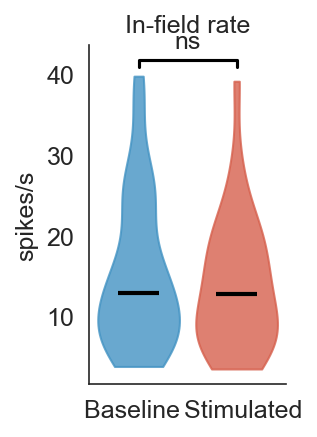

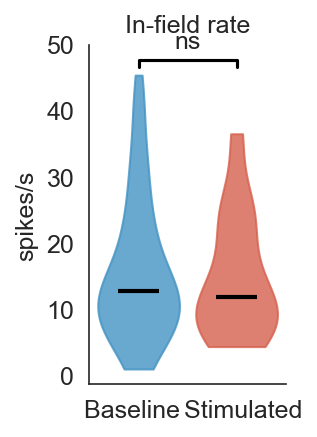

In [54]:

for key, data in stuff.items():
    baseline = data['base']['in_field_mean_rate'].to_numpy()
    stimulated = data['stim']['in_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("In-field rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.1, 18)

    plt.savefig(output_path / "figures" / f"in_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"in_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5346.0 p value 0.837723677011064
U-test: U value 1139.0 p value 0.7090314211265186
U-test: U value 797.0 p value 0.8936946693232326


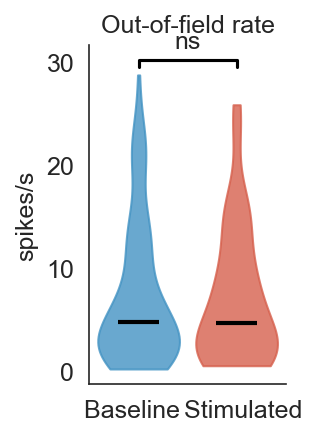

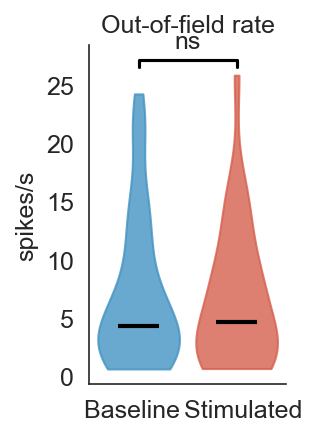

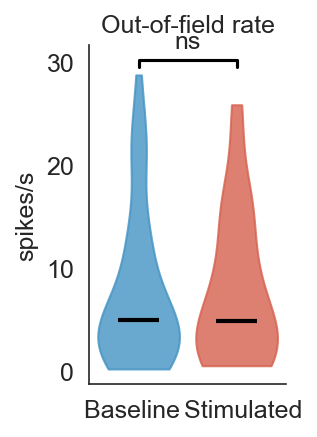

In [55]:

for key, data in stuff.items():
    baseline = data['base']['out_field_mean_rate'].to_numpy()
    stimulated = data['stim']['out_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Out-of-field rate")
    plt.ylabel("spikes/s")
    # plt.ylim(-0.2, 8)

    plt.savefig(output_path / "figures" / f"out_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"out_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5835.0 p value 0.18556878084894968
U-test: U value 1018.0 p value 0.6075645264212683
U-test: U value 983.0 p value 0.11611024526570707


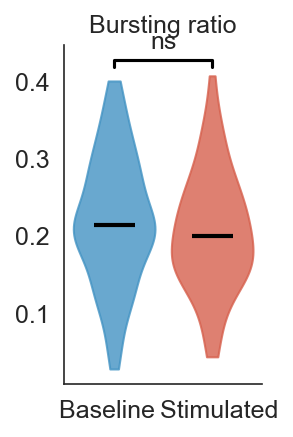

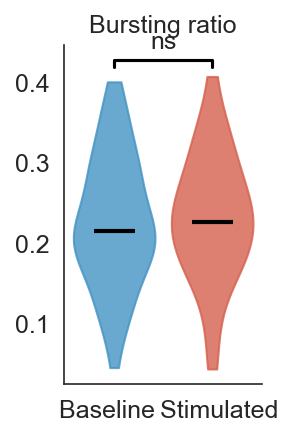

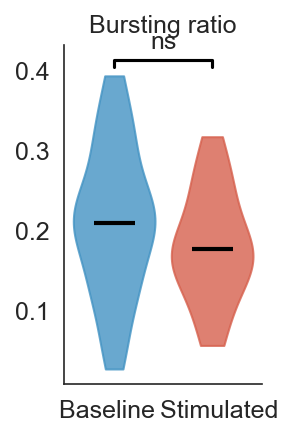

In [56]:
for key, data in stuff.items():
    baseline = data['base']['burst_event_ratio'].to_numpy()
    stimulated = data['stim']['burst_event_ratio'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Bursting ratio")
    plt.ylabel("")
    # plt.ylim(-0.02, 0.60)

    plt.savefig(output_path / "figures" / f"burst_event_ratio{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"burst_event_ratio{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5445.0 p value 0.6662129955034535
U-test: U value 1097.0 p value 0.9499188826627789
U-test: U value 889.0 p value 0.4807998283550271


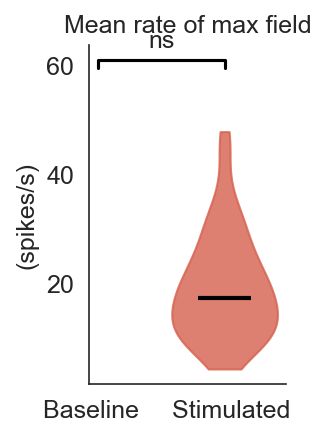

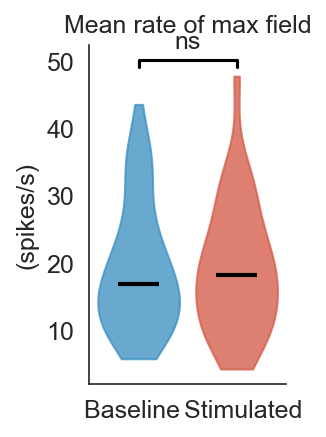

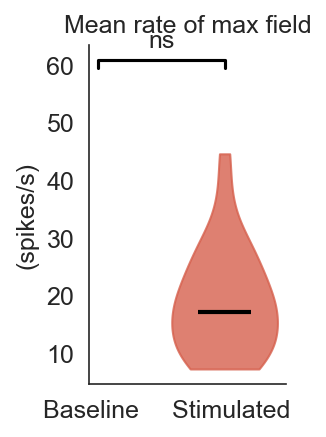

In [57]:
for key, data in stuff.items():
    baseline = data['base']['max_field_mean_rate'].to_numpy()
    stimulated = data['stim']['max_field_mean_rate'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Mean rate of max field")
    plt.ylabel("(spikes/s)")
    # plt.ylim(-0.5,25)

    plt.savefig(output_path / "figures" / f"max_field_mean_rate{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"max_field_mean_rate{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 5912.0 p value 0.13361338521771
U-test: U value 1033.0 p value 0.6871584526572116
U-test: U value 998.0 p value 0.08734905208437223


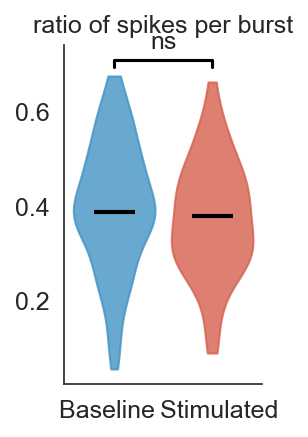

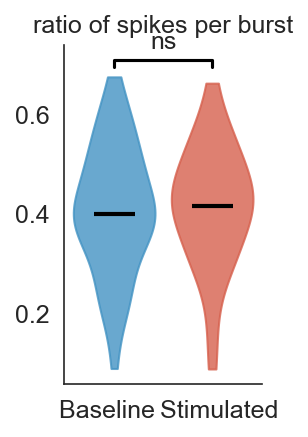

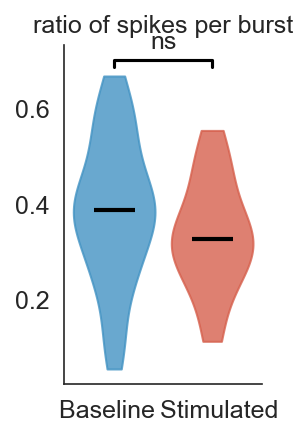

In [58]:
for key, data in stuff.items():
    baseline = data['base']['bursty_spike_ratio'].to_numpy()
    stimulated = data['stim']['bursty_spike_ratio'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("ratio of spikes per burst")
    plt.ylabel("")
    # plt.ylim(-0.03,0.9)

    plt.savefig(output_path / "figures" / f"bursty_spike_ratio{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"bursty_spike_ratio{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 6794.0 p value 0.00043429512252855416
U-test: U value 1500.0 p value 0.002360466792504703
U-test: U value 1131.0 p value 0.0033326217809176804


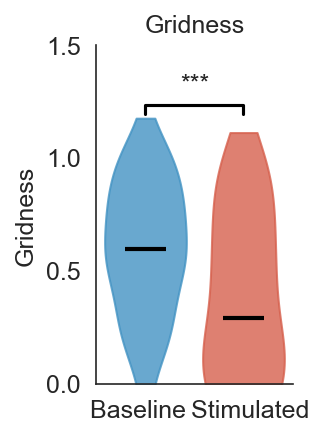

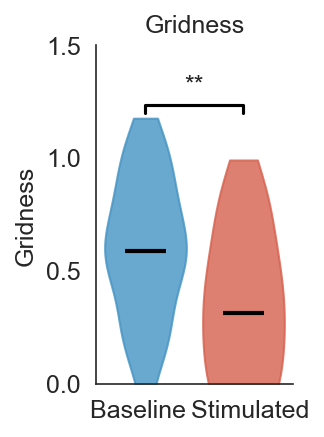

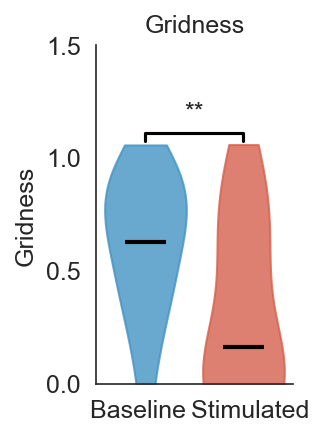

In [59]:

for key, data in stuff.items():
    baseline = data['base']['gridness'].to_numpy()
    stimulated = data['stim']['gridness'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Gridness")
    plt.ylabel("Gridness")
    plt.ylim(-0.005, 1.5)

    plt.savefig(output_path / "figures" / f"gridness{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"gridness{key}.png", dpi=600, bbox_inches="tight")

U-test: U value 6534.0 p value 0.003462885676336014
U-test: U value 1440.0 p value 0.00939537597606729
U-test: U value 1007.0 p value 0.07305394917377077


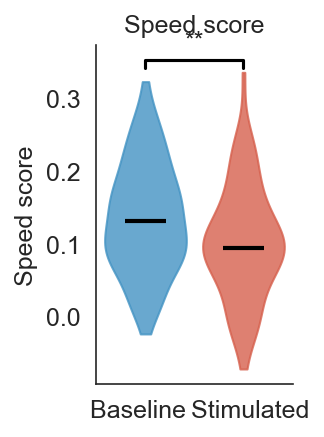

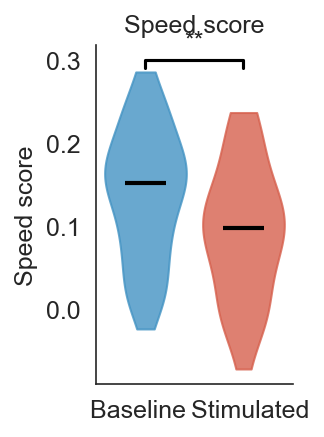

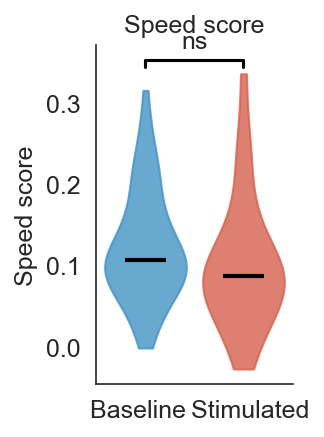

In [60]:
for key, data in stuff.items():
    baseline = data['base']['speed_score'].to_numpy()
    stimulated = data['stim']['speed_score'].to_numpy()
    plt.figure()
    violinplot(baseline, stimulated)
    plt.title("Speed score")
    plt.ylabel("Speed score")
    # plt.ylim(-0.1, 0.5)

    plt.savefig(output_path / "figures" / f"speed_score{key}.svg", bbox_inches="tight")
    plt.savefig(output_path / "figures" / f"speed_score{key}.png", dpi=600, bbox_inches="tight")

# Register in Expipe

In [44]:
action = project.require_action("comparisons-gridcells")

In [45]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_base_i_vs_base_ii.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11_vs_30.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-gridcells/data/statistics/statistics_11_vs_30.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-

In [46]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_gridcells.ipynb")